In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sim.Box2DSim import Box2DSim, InlineTestPlotter
from DMp.bbo import BBO, rew_softmax


In [2]:

dmp_num_theta = 20
dmp_stime = 100
dmp_dt = 0.3
dmp_sigma = 0.1

bbo_lmb = 0.5
bbo_epochs = 80
bbo_K = 30
bbo_num_dmps = 4
bbo_sigma = 1.0e-06
bbo_sigma_decay_amp = 0.2
bbo_sigma_decay_period = 1.0

# define a callable with a single step of the simulation
class Simulation:
    def __init__(self, rollout):
        """
        :param rollout: np.array(bbo_K, dmp_stime). A single rollout 
                        from which joint commands are taken
        :return: np.array(int). contacts
        """
        self.t = 0
        self.rollout = rollout   
    def __call__(self, sim):    
        """
        :param sim: Box2DSim. The simulator object
        """
        sim.move("Arm1_to_Arm2", -0.5*np.pi*self.rollout[0, self.t])
        sim.move("Arm2_to_Arm3", -0.5*np.pi*self.rollout[1, self.t])
        sim.move("Arm2_to_Arm3", -0.5*np.pi*self.rollout[2, self.t])
        sim.move("Arm3_to_Claw10", -0.5*np.pi*(1-self.rollout[3, self.t]))
        sim.move("Arm3_to_Claw20", 0.5*np.pi*(1-self.rollout[3, self.t]))
        # do the movement
        sim.step()
        
        # get contacts form the claws (they are sensors)
        contacts = [
            sim.contacts("claw10", "Object"),
            sim.contacts("claw11", "Object"),
            sim.contacts("claw20", "Object"),
            sim.contacts("claw21", "Object")]     
        self.t += 1  
        return contacts

def rew_func(rollouts):  
    """
    reward function
    :param rollouts: np.array(bbo_num_rollouts, dmp_stime) 
                  the rollouts of an epoch
    """
    rews = np.zeros([rollouts.shape[1], rollouts.shape[2]])
    for k in range(rollouts.shape[1]):
        simulate_step = Simulation(np.squeeze(rollouts[:,k,:]))
        sim = Box2DSim("body2d.json")
        for t in range(rollouts.shape[2]):
            rews[k, t] = np.sum(simulate_step(sim))
    return rews.reshape(1, *rews.shape)

# the BBO object
bbo = BBO(num_params=dmp_num_theta, 
          dmp_stime=dmp_stime, dmp_dt=dmp_dt, dmp_sigma=dmp_sigma,
          num_rollouts=bbo_K, num_dmps=bbo_num_dmps,
          sigma=bbo_sigma, lmb=bbo_lmb, epochs=bbo_epochs,
          sigma_decay_amp=bbo_sigma_decay_amp, 
          sigma_decay_period=bbo_sigma_decay_period, 
          softmax=rew_softmax, cost_func=rew_func)


In [3]:
rew = np.zeros(bbo_epochs)
for k in range(bbo_epochs):
    rs, rew[k] = bbo.iteration()
    if k % 10 == 0 or k == bbo_epochs -1 : print k
rs,_ = bbo.iteration(explore=False)
rs = np.array(rs)

0
10
20
30
40
50
60
70
79


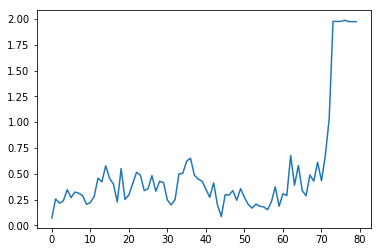

In [4]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(rew)
plt.show()

In [5]:
# create the simulator
inline_sim = Box2DSim("body2d.json")
# create the plot environment
plotter = InlineTestPlotter(inline_sim, sim_step=Simulation(np.squeeze(rs[:,0,:])))
# run the simulation so to produce the video
ani = plotter.makeVideo(frames=dmp_stime-2)
# show the video of the simulation
from IPython.display import HTML
HTML(ani.to_html5_video())